# Partitioning

Two methods are available to partition 2D wave spectra:

* Frequency split
* Watershed

In [1]:
from pathlib import Path
import matplotlib.pyplot as plt

from wavespectra import read_ww3

datadir = Path("../data")

dset = read_ww3(datadir / "ww3file.nc")
dset

<xarray.Dataset>
Dimensions:  (dir: 24, time: 9, site: 2, freq: 25)
Coordinates:
  * dir      (dir) float32 270.0 255.0 240.0 225.0 ... 330.0 315.0 300.0 285.0
  * freq     (freq) float32 0.04118 0.0453 0.04983 ... 0.3352 0.3687 0.4056
  * site     (site) int32 1 2
  * time     (time) datetime64[ns] 2014-12-01 2014-12-01T12:00:00 ... 2014-12-05
Data variables:
    dpt      (time, site) float32 dask.array<chunksize=(9, 2), meta=np.ndarray>
    efth     (time, site, freq, dir) float32 dask.array<chunksize=(9, 2, 25, 24), meta=np.ndarray>
    lat      (site) float32 dask.array<chunksize=(2,), meta=np.ndarray>
    lon      (site) float32 dask.array<chunksize=(2,), meta=np.ndarray>
    wspd     (time, site) float32 dask.array<chunksize=(9, 2), meta=np.ndarray>
    wdir     (time, site) float32 dask.array<chunksize=(9, 2), meta=np.ndarray>

## Frequency split

In [3]:
fcut = 1 / 8

sea = dset.spec.split(fmin=fcut)
swell = dset.spec.split(fmax=fcut)

print("Full spectrum\n", dset.freq.values)
print("Sea\n", sea.freq.values)
print("Swell\n", swell.freq.values)

Full spectrum
 [0.04118    0.045298   0.0498278  0.05481058 0.06029164 0.06632081
 0.07295289 0.08024818 0.08827299 0.09710029 0.10681032 0.11749136
 0.1292405  0.14216454 0.15638101 0.17201911 0.18922101 0.20814312
 0.22895744 0.25185317 0.27703848 0.30474234 0.3352166  0.36873826
 0.40561208]
Sea
 [0.125      0.1292405  0.14216454 0.15638101 0.17201911 0.18922101
 0.20814312 0.22895744 0.25185317 0.27703848 0.30474234 0.33521661
 0.36873826 0.40561208]
Swell
 [0.04118    0.045298   0.0498278  0.05481058 0.06029164 0.06632081
 0.07295289 0.08024818 0.08827299 0.09710029 0.10681032 0.11749136
 0.125     ]


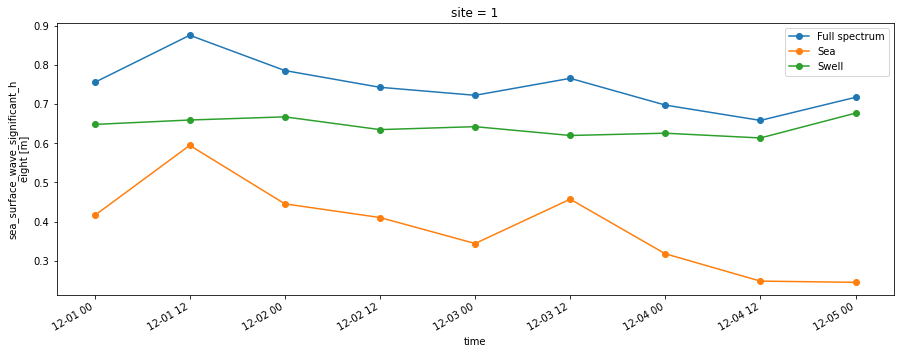

In [4]:
fig = plt.figure(figsize=(15, 5))

dset.spec.hs().isel(site=0).plot(label='Full spectrum', marker='o');
sea.spec.hs().isel(site=0).plot(label='Sea', marker='o');
swell.spec.hs().isel(site=0).plot(label='Swell', marker='o');
plt.legend();

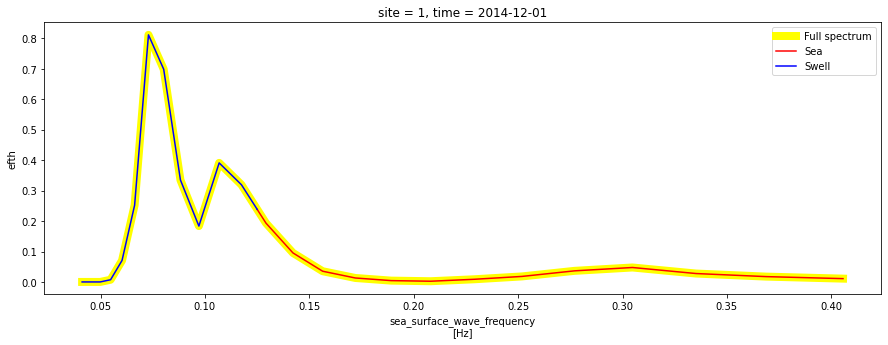

In [5]:
fig = plt.figure(figsize=(15, 5))

dset.isel(site=0, time=0).spec.oned().plot(label="Full spectrum", linewidth=8, color="yellow");
sea.isel(site=0, time=0).spec.oned().plot(label="Sea", color="red");
swell.isel(site=0, time=0).spec.oned().plot(label="Swell", color="blue");
plt.legend();

## Watershed

The watershed method is modified from WW3 Fortran src code for speed. The method requires water depth, wind speed and direction as main inputs. The output is a Dataset with an extra `par` dimension where the first index corresponds to the wind-forced partition and the remaining indices are the different swells available sorted by Hs.

In [6]:
dset.spec.partition?

Signature:
dset.spec.partition(
    wsp_darr,
    wdir_darr,
    dep_darr,
    swells=3,
    agefac=1.7,
    wscut=0.3333,
)
Docstring:
Partition wave spectra using Hanson's watershed algorithm.

This method is not lazy, make sure array will fit into memory.

Args:
    - wsp_darr (DataArray): wind speed (m/s).
    - wdir_darr (DataArray): Wind direction (degree).
    - dep_darr (DataArray): Water depth (m).
    - swells (int): Number of swell partitions to compute.
    - agefac (float): Age factor.
    - wscut (float): Wind speed cutoff.

Returns:
    - part_spec (SpecArray): partitioned spectra with one extra dimension
      representig partition number.

Note:
    - Input DataArrays must have same non-spectral dims as SpecArray.

References:
    - Hanson, Jeffrey L., et al. "Pacific hindcast performance of three
      numerical wave models." JTECH 26.8 (2009): 1614-1633.
File:      /source/wavespectra/wavespectra/specarray.py
Type:      method


In [7]:
dspart = dset.spec.partition(dset.wspd, dset.wdir, dset.dpt)
dspart

<xarray.DataArray 'efth' (part: 4, time: 9, site: 2, freq: 25, dir: 24)>
dask.array<transpose, shape=(4, 9, 2, 25, 24), dtype=float32, chunksize=(4, 9, 2, 25, 24), chunktype=numpy.ndarray>
Coordinates:
  * dir      (dir) float32 270.0 255.0 240.0 225.0 ... 330.0 315.0 300.0 285.0
  * freq     (freq) float32 0.04118 0.0453 0.04983 ... 0.3352 0.3687 0.4056
  * site     (site) int32 1 2
  * time     (time) datetime64[ns] 2014-12-01 2014-12-01T12:00:00 ... 2014-12-05
  * part     (part) int64 0 1 2 3

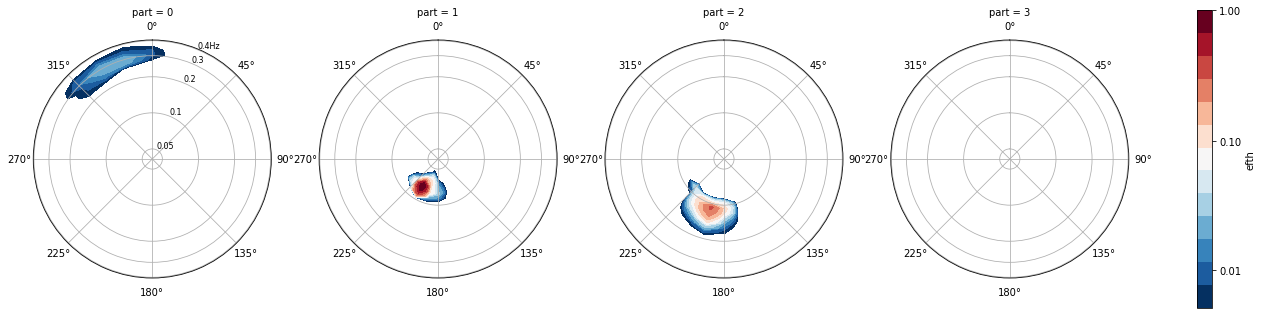

In [8]:
dspart.isel(time=0, site=0).spec.plot(col="part", figsize=(20, 5));

Spectral statistics can be calculated for individual partitions:

In [9]:
pstats = dspart.spec.stats(["hs", "dpm"])
pstats

<xarray.Dataset>
Dimensions:  (site: 2, time: 9, part: 4)
Coordinates:
  * site     (site) int32 1 2
  * time     (time) datetime64[ns] 2014-12-01 2014-12-01T12:00:00 ... 2014-12-05
  * part     (part) int64 0 1 2 3
Data variables:
    hs       (part, time, site) float64 dask.array<chunksize=(4, 9, 2), meta=np.ndarray>
    dpm      (part, time, site) float32 dask.array<chunksize=(4, 9, 2), meta=np.ndarray>
Attributes:
    standard_name:  sea_surface_wave_significant_height
    units:          m

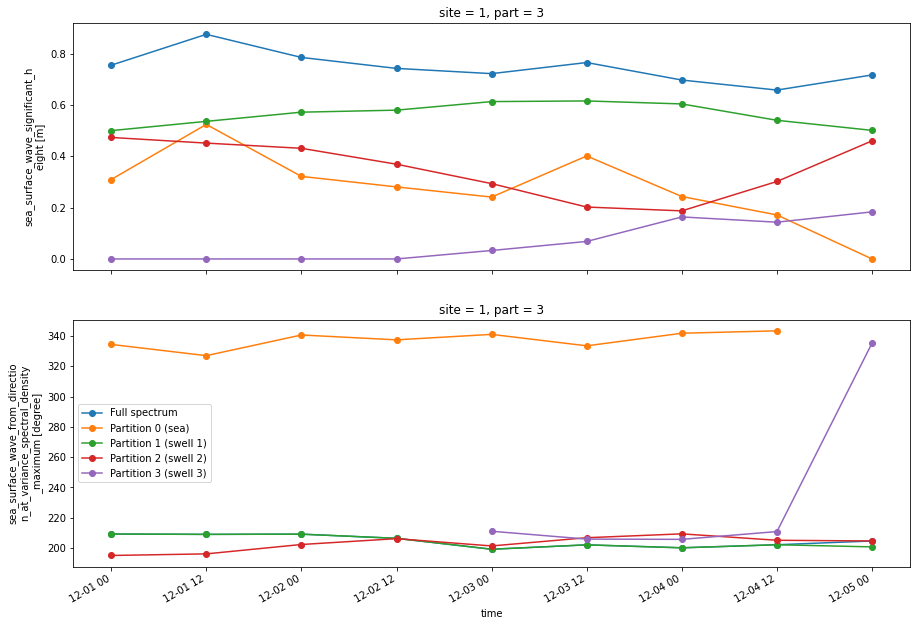

In [10]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(15, 10))

dset.spec.hs().isel(site=0).plot(ax=ax1, label='Full spectrum', marker='o');
pstats.hs.isel(part=0, site=0).plot(ax=ax1, label='Partition 0 (sea)', marker='o');
pstats.hs.isel(part=1, site=0).plot(ax=ax1, label='Partition 1 (swell 1)', marker='o');
pstats.hs.isel(part=2, site=0).plot(ax=ax1, label='Partition 2 (swell 2)', marker='o');
pstats.hs.isel(part=3, site=0).plot(ax=ax1, label='Partition 3 (swell 3)', marker='o');
ax1.set_xlabel("")
ax1.set_xticklabels("")

dset.spec.dpm().isel(site=0).plot(ax=ax2, label='Full spectrum', marker='o');
pstats.dpm.isel(part=0, site=0).plot(ax=ax2, label='Partition 0 (sea)', marker='o');
pstats.dpm.isel(part=1, site=0).plot(ax=ax2, label='Partition 1 (swell 1)', marker='o');
pstats.dpm.isel(part=2, site=0).plot(ax=ax2, label='Partition 2 (swell 2)', marker='o');
pstats.dpm.isel(part=3, site=0).plot(ax=ax2, label='Partition 3 (swell 3)', marker='o');
plt.legend();